## COVID19 Modeling the Spread of the Coronavirus

Data on the spread of the Coronavirus that causes COVID19 are derived from the [Johns Hopkins CSSE](https://github.com/CSSEGISandData/COVID-19) via an API setup by [Kyle Redelinghuys](https://covid19api.com/).

The spread of the virus is both visualized and modeled, initially across the globe and then in individual countries such as the United States and China.


### Daily Executive Summaries
 - As of __March 14__ (with data as of March 13), about 173,000 confirmed cases are predicted to be reached by April 1st, 2020 based on a Prophet time series forecasting model with a maximal RMSE of 23,720. However, while the rate of new cases in China is flatling, the rate of new cases in the United States is increasing exponentially. This suggests that the model is predicting many fewer cases that will likely be observed as testing ramps up in the United States. 
 - As of __March 15__, a new model now predicts anout 179,000 confirmed cases to be reached by April 2nd, 2020 with a maximal RMSE of 28,500. China's new infection rate is flat. However, the United States continues to exhibit an exponential increase in the number of new cases.  
 - As of __March 16__, a model predicts that if the current rate of new confirmed cases in the US continues, that there will be 243,991 cumulative confirmed cases in the United States on April 1, 2020. This model was trained on a Log base 10 transformed cumulative number of cases in the US because the current trend is one of exponential growth. This model also predicts that by the end of today, March 16th, that there will be a total of 4,555 confirmed cases in the US. 
 - As of __March 17__, the exponential growth trend in the United States continues. The model now predicts 5,877 cumulative confirmed cases in the United States by the end of the 17th (currently at 5,702 as of 11:15 am PST). The April 1st estimated number of cases at the current rate now stands at 262,777. This is an increase of over nearly 20,000 cumulative confirmed cases over yesterday's model. 
 - As of __March 18__, the exponential growth of cumulative cases is outpacing the model trained on the log transformed data. Increased testing across the US (as testing capacity finally rolls out) is leading to the number of cases jumping dramatically. While 5,877 cumulative confirmed cases was predicted for yesterday, the actual number of cumulative confirmed cases as of yesterday was 6,421. A model trained today predicts a total of 7,111 by the end of 3-18, but the [John's Hopkins Tracker](https://www.arcgis.com/apps/opsdashboard/index.html#/bda7594740fd40299423467b48e9ecf6) already shows 7,324 cumulative confirmed cases in the United States as of 10am PDT. This model predicts 289,014 cumulative confirmed cases in the United States on April 1st. 
 - __March 19__ saw the API all call go down. Due to other obligations, I was unable to run an assessment for this date. 
 - As of __March 20__, the growth trend of new cases is exceeding the exponential trend seen previously. A model trained with data as of March 19 predicts some 13,884 for March 20, which has already been surpassed as of 11am PDT with 14,250 cases. This model predicts some 382,899 cases in just 12 days on April 1st. 



In [18]:
import pandas as pd
import numpy as np
import datetime as dt
from datetime import date
from datetime import datetime, timedelta
from fbprophet import Prophet
from fbprophet.diagnostics import performance_metrics
from fbprophet.diagnostics import cross_validation

In [2]:
import altair as alt
alt.renderers.enable('notebook')
alt.data_transformers.disable_max_rows()

DataTransformerRegistry.enable('default')

In [3]:
# Ensure notebook takes up full width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [6]:
# Supress warning messages
import warnings
warnings.filterwarnings('ignore')
#warnings.filterwarnings(action='once')

In [7]:
covid19 = pd.read_json('https://api.covid19api.com/all')
covid19.tail()

,Country,Province,Lat,Lon,Date,Cases,Status
83764,Zambia,,-15.4167,28.2833,2020-03-18 00:00:00+00:00,0,recovered
83765,Zambia,,-15.4167,28.2833,2020-03-18 00:00:00+00:00,0,deaths
83766,Zambia,,-15.4167,28.2833,2020-03-19 00:00:00+00:00,2,confirmed
83767,Zambia,,-15.4167,28.2833,2020-03-19 00:00:00+00:00,0,deaths
83768,Zambia,,-15.4167,28.2833,2020-03-19 00:00:00+00:00,0,recovered


In [8]:
summed_covid19 = covid19.groupby([covid19['Status'], covid19['Date']]).sum().reset_index()

In [9]:
print('Number of cases by status of of yesterday, ' + str(date.today() - timedelta(days=1)) + " :")
summed_covid19.loc[summed_covid19['Date'] == str(date.today() - timedelta(days=1))][['Status', 'Date', 'Cases']]

Number of cases by status of of yesterday, 2020-03-19 :


,Status,Date,Cases
57,confirmed,2020-03-19 00:00:00+00:00,242708
115,deaths,2020-03-19 00:00:00+00:00,9867
173,recovered,2020-03-19 00:00:00+00:00,84854


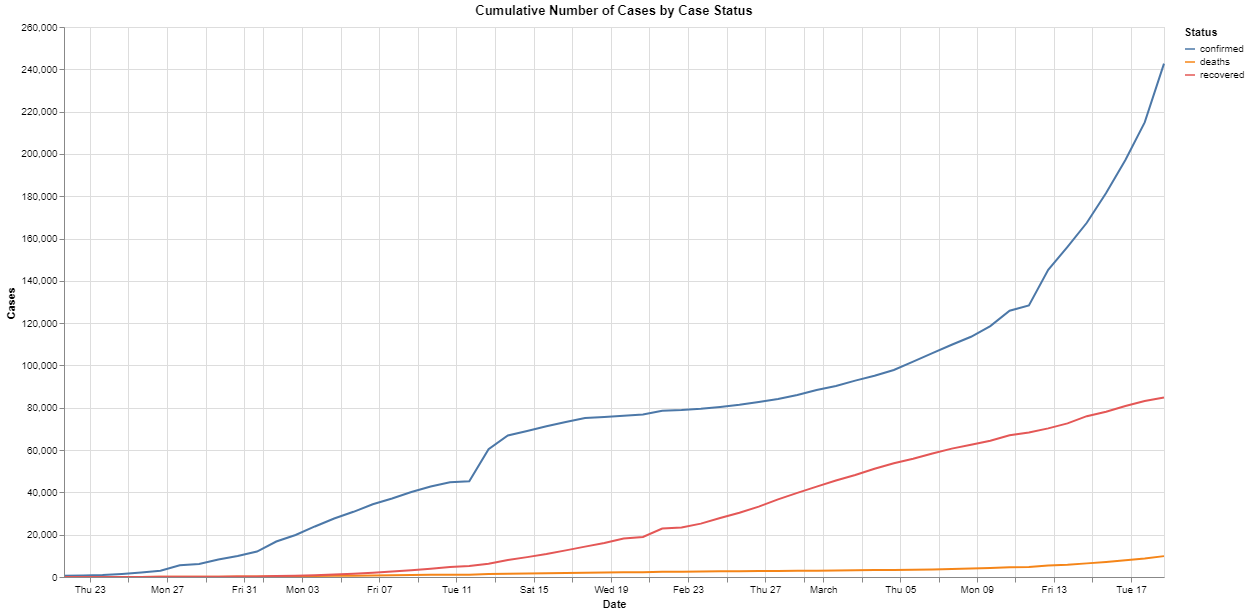

In [10]:
source = summed_covid19
alt.Chart(source).mark_line().encode(
    x='Date:T',
    y='Cases:Q',
    color='Status:N'
).properties(width=1100, height=550, title='Cumulative Number of Cases by Case Status')#.configure_axis(labelFontSize=4)

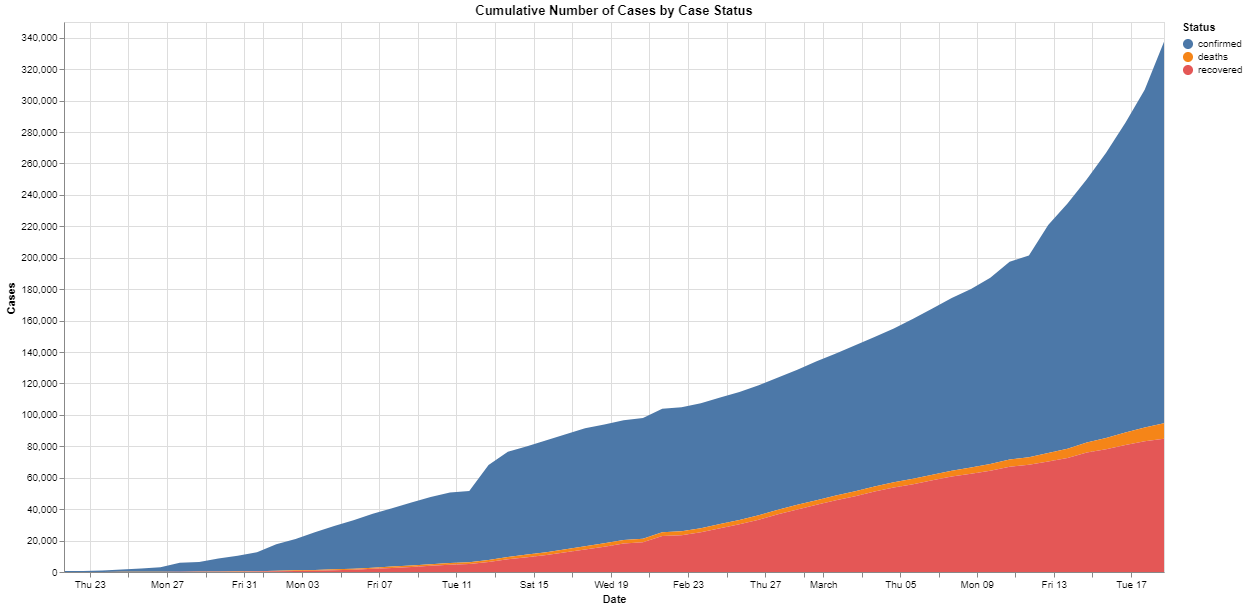

In [11]:
source = summed_covid19

alt.Chart(source).mark_area().encode(
    x='Date:T',
    y='Cases:Q',
    color='Status:N'
).properties(width=1100, height=550, title='Cumulative Number of Cases by Case Status')

In [20]:
# Data handling for prophet
summed_covid19.Date = pd.to_datetime(summed_covid19.Date)
summed_covid19['ds'] = summed_covid19.Date.dt.tz_localize(None)
summed_covid19['y'] = summed_covid19.Cases
summed_covid19.tail()

,Status,Date,Lat,Lon,Cases,ds,y
169,recovered,2020-03-15 00:00:00+00:00,14970.4547,-16668.6413,76034,2020-03-15,76034
170,recovered,2020-03-16 00:00:00+00:00,14970.4547,-16668.6413,78088,2020-03-16,78088
171,recovered,2020-03-17 00:00:00+00:00,14920.6019,-16768.1943,80840,2020-03-17,80840
172,recovered,2020-03-18 00:00:00+00:00,14797.4141,-16692.4920,83207,2020-03-18,83207
173,recovered,2020-03-19 00:00:00+00:00,14701.4572,-16573.8877,84854,2020-03-19,84854


In [21]:
df_m_confirmed = summed_covid19.loc[summed_covid19['Status'] == 'confirmed'][['ds', 'y']]
df_m_recovered = summed_covid19.loc[summed_covid19['Status'] == 'recovered'][['ds', 'y']]
df_m_deaths = summed_covid19.loc[summed_covid19['Status'] == 'deaths'][['ds', 'y']]

In [22]:
print('Number of days of virus monitoring: ' + str(df_m_confirmed.ds.count()))

Number of days of virus monitoring: 58


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


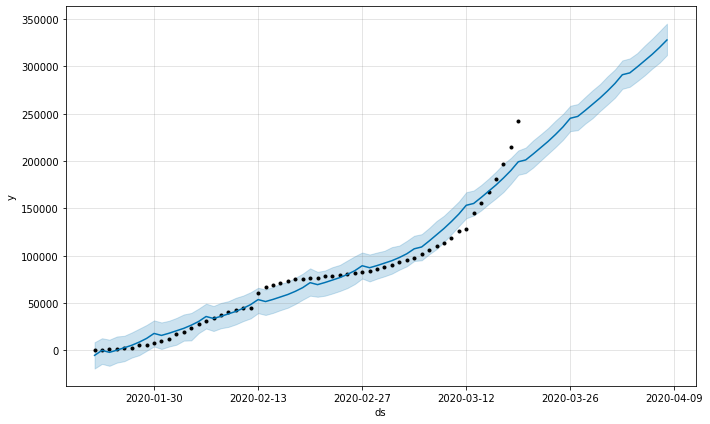

In [23]:
# Train a Prophet model to untransformed, aggregate number of cases across the globe
m_confirmed = Prophet()
m_confirmed.fit(df_m_confirmed)
future = m_confirmed.make_future_dataframe(periods=20)
forecast_confirmed = m_confirmed.predict(future)
m_confirmed.plot(forecast_confirmed);

As of `2020-03-17` it appears that I may need to shift to modeling log transformed data instead of the untransformed data. 

In [24]:
forecast_confirmed[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(5)

,ds,yhat,yhat_lower,yhat_upper
73,2020-04-04,299420.027092,284327.416257,314005.422525
74,2020-04-05,306022.130230,290534.037580,321902.409605
75,2020-04-06,312652.839016,297566.124221,329182.752325
76,2020-04-07,319986.877971,303847.411279,337065.379353
77,2020-04-08,327920.080677,311905.917171,345176.052959


In [25]:
df_cv = cross_validation(m_confirmed, initial='26 days', period='14 days', horizon = '5 days')
df_cv.tail(50)

INFO:fbprophet:Making 2 forecasts with cutoffs between 2020-02-29 00:00:00 and 2020-03-14 00:00:00


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2020-03-01,98959.381355,91255.139424,106741.268276,88369,2020-02-29
1,2020-03-02,100785.659334,93237.950770,108309.511600,90306,2020-02-29
2,2020-03-03,103066.922145,95366.795473,110300.741933,92840,2020-02-29
3,2020-03-04,106062.181397,98015.354714,113730.281644,95120,2020-02-29
4,2020-03-05,109793.847609,101446.481016,117540.601954,97882,2020-02-29
5,2020-03-15,132953.002944,124265.323751,142328.299865,167458,2020-03-14
6,2020-03-16,135075.051676,125725.984216,144450.835289,181559,2020-03-14
7,2020-03-17,137787.756374,127575.534124,147115.272822,197152,2020-03-14
8,2020-03-18,141296.194389,132698.911558,150231.310760,214912,2020-03-14
9,2020-03-19,144752.283747,136001.390484,154486.585561,242708,2020-03-14


In [26]:
df_p = performance_metrics(df_cv)
df_p

,horizon,mse,rmse,mae,mape,coverage
0,1 days,6.513755e+08,25522.059077,22547.689205,0.162947,0.0
1,2 days,1.135290e+09,33694.070038,28481.803829,0.186036,0.0
2,3 days,1.814352e+09,42595.207229,34795.582885,0.205633,0.0
3,4 days,2.769509e+09,52626.125496,42278.993504,0.228787,0.0
4,5 days,4.868607e+09,69775.405625,54933.781931,0.262645,0.0


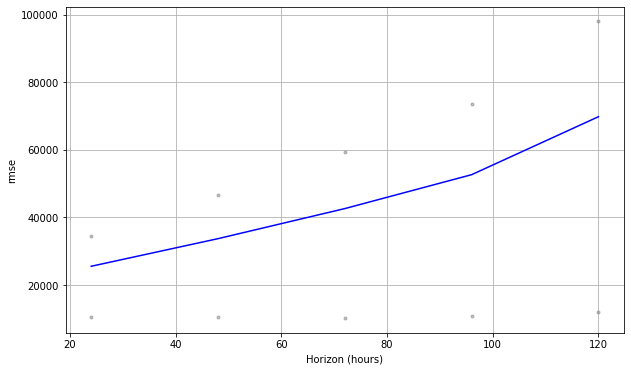

In [27]:
from fbprophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='rmse')

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


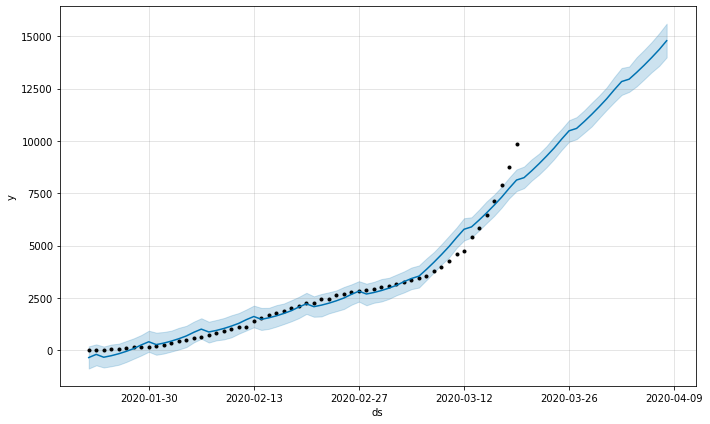

In [29]:
m_deaths = Prophet()
m_deaths.fit(df_m_deaths)
future = m_deaths.make_future_dataframe(periods=20)
forecast_deaths = m_deaths.predict(future)
m_deaths.plot(forecast_deaths);

In [30]:
forecast_deaths.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
73,2020-04-04,13353.921633,12610.573697,13999.502039,12936.464637,13766.191156,-78.063323,-78.063323,-78.063323,-78.063323,-78.063323,-78.063323,0.0,0.0,0.0,13275.858310
74,2020-04-05,13690.139951,12944.046061,14351.708725,13232.668949,14138.224408,-70.372086,-70.372086,-70.372086,-70.372086,-70.372086,-70.372086,0.0,0.0,0.0,13619.767865
75,2020-04-06,14026.358268,13284.837849,14727.607916,13530.392204,14512.914405,-42.192834,-42.192834,-42.192834,-42.192834,-42.192834,-42.192834,0.0,0.0,0.0,13984.165434
76,2020-04-07,14362.576586,13587.016917,15145.666438,13831.750702,14892.605222,4.106007,4.106007,4.106007,4.106007,4.106007,4.106007,0.0,0.0,0.0,14366.682593
77,2020-04-08,14698.794903,13996.546128,15607.335775,14115.889063,15273.785362,92.846484,92.846484,92.846484,92.846484,92.846484,92.846484,0.0,0.0,0.0,14791.641387


In [31]:
summed_covid19_by_country = covid19.groupby([covid19['Status'], covid19['Country'], covid19['Date']]).sum().reset_index()
summed_covid19_by_country.head()

,Status,Country,Date,Lat,Lon,Cases
0,confirmed,Afghanistan,2020-01-22 00:00:00+00:00,33.0,65.0,0
1,confirmed,Afghanistan,2020-01-23 00:00:00+00:00,33.0,65.0,0
2,confirmed,Afghanistan,2020-01-24 00:00:00+00:00,33.0,65.0,0
3,confirmed,Afghanistan,2020-01-25 00:00:00+00:00,33.0,65.0,0
4,confirmed,Afghanistan,2020-01-26 00:00:00+00:00,33.0,65.0,0


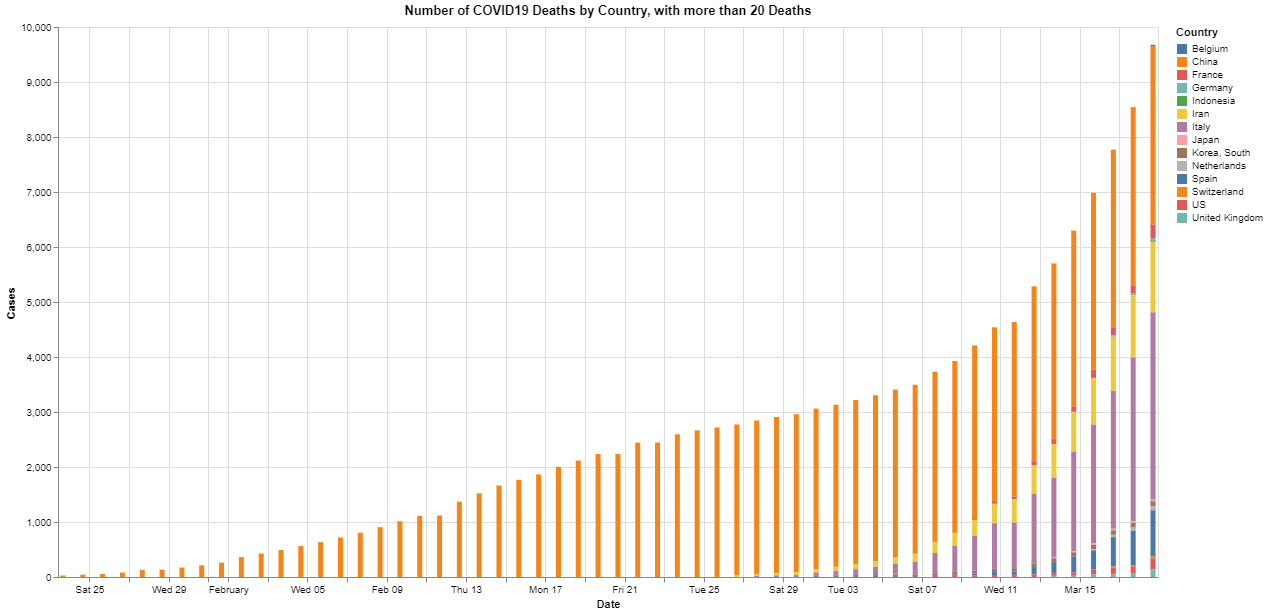

In [32]:
source = summed_covid19_by_country.loc[(summed_covid19_by_country['Status'] == 'deaths') & (summed_covid19_by_country['Cases'] > 20)]

alt.Chart(source).mark_bar().encode(
    x='Date',
    y='Cases',
    color='Country'
).properties(width=1100, height=550, title='Number of COVID19 Deaths by Country, with more than 20 Deaths')

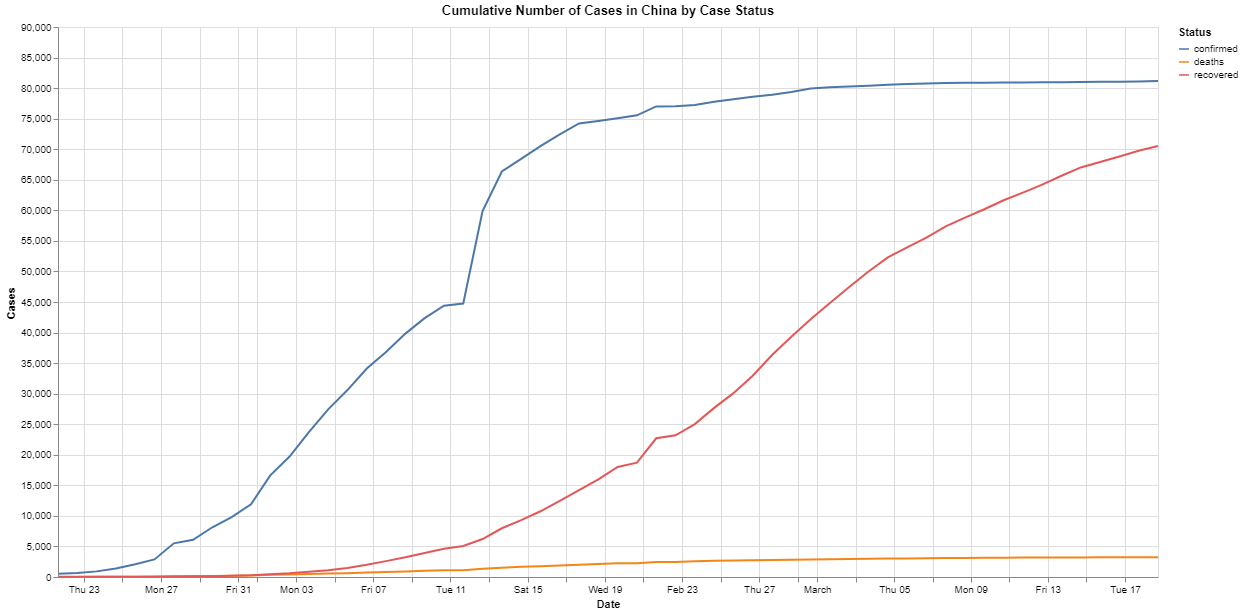

In [33]:
source = summed_covid19_by_country.loc[summed_covid19_by_country['Country'] == 'China']
alt.Chart(source).mark_line().encode(
    x='Date:T',
    y='Cases:Q',
    color='Status:N'
).properties(width=1100, height=550, title='Cumulative Number of Cases in China by Case Status')

In [37]:
# Data handling for prophet
summed_covid19_by_country.Date = pd.to_datetime(summed_covid19_by_country.Date)
summed_covid19_by_country['ds'] = summed_covid19_by_country.Date.dt.tz_localize(None)
summed_covid19_by_country['y'] = summed_covid19_by_country.Cases

df_m_confirmed_china = summed_covid19_by_country.loc[(summed_covid19_by_country['Status'] == 'confirmed') & (summed_covid19_by_country['Country'] == 'China')][['ds', 'y']]

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


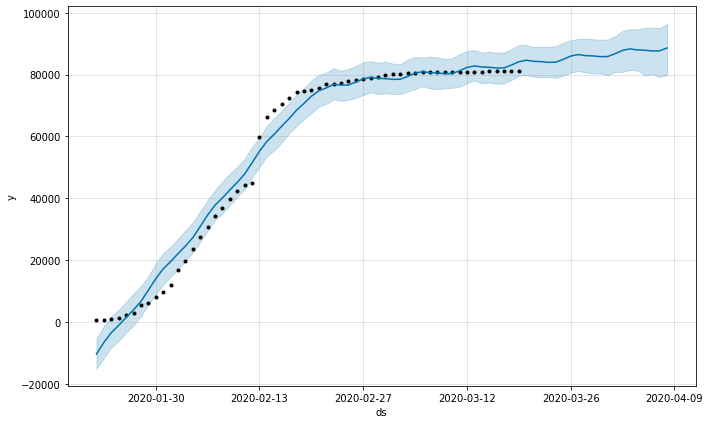

In [38]:
# Prophet forecast for China
m_confirmed_china = Prophet()
m_confirmed_china.fit(df_m_confirmed_china)
future = m_confirmed_china.make_future_dataframe(periods=20)
forecast_confirmed_china = m_confirmed_china.predict(future)
m_confirmed_china.plot(forecast_confirmed_china);

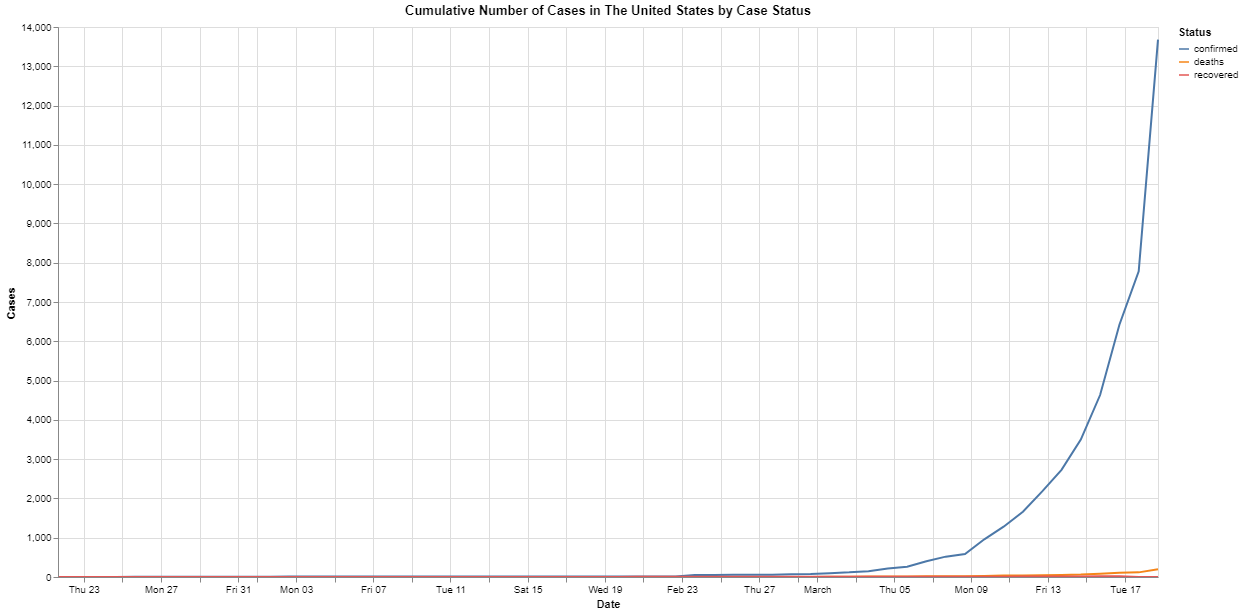

In [39]:
source = summed_covid19_by_country.loc[summed_covid19_by_country['Country'] == 'US']
alt.Chart(source).mark_line().encode(
    x='Date:T',
    y='Cases:Q',
    color='Status:N'
).properties(width=1100, height=550, title='Cumulative Number of Cases in The United States by Case Status')#.configure_axis(labelFontSize=4)

In [40]:
summed_covid19_by_country.loc[(summed_covid19_by_country['Country'] == 'US') & (summed_covid19_by_country['Date'] == str(date.today() - timedelta(days=1)))]

,Status,Country,Date,Lat,Lon,Cases,ds,y
9249,confirmed,US,2020-03-19 00:00:00+00:00,9531.0034,-22951.8162,13677,2020-03-19,13677
19018,deaths,US,2020-03-19 00:00:00+00:00,9531.0034,-22951.8162,200,2020-03-19,200
28787,recovered,US,2020-03-19 00:00:00+00:00,9531.0034,-22951.8162,0,2020-03-19,0


In [41]:
df_confirmed_us = summed_covid19_by_country.loc[(summed_covid19_by_country['Status'] == 'confirmed') & (summed_covid19_by_country['Country'] == 'US')][['ds', 'y']]

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


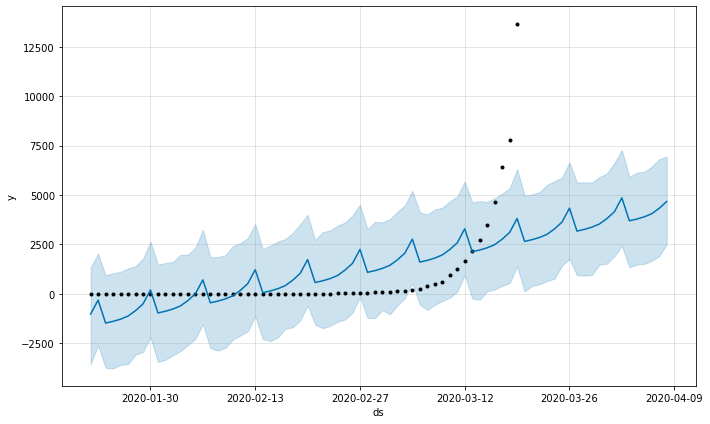

In [42]:
# Prophet forecast for the US
m_confirmed_us = Prophet()
m_confirmed_us.fit(df_confirmed_us)
future = m_confirmed_us.make_future_dataframe(periods=20)
forecast_confirmed_us = m_confirmed_us.predict(future)
m_confirmed_us.plot(forecast_confirmed_us);

This is obviously fitting terribly due to the exponential growth trend. In order to fit a linear model to an exponential trend, we need to transform the data - log 10 is a good place to start.

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


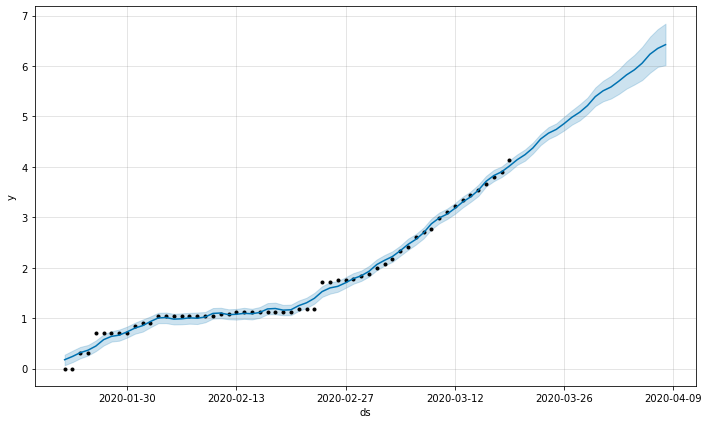

In [43]:
# Log transform the number of confirmed US cases
#… logging converts multiplicative relationships to additive relationships, and by the same token it converts exponential (compound growth) trends to linear trends. 
# By taking logarithms of variables which are multiplicatively related and/or growing exponentially over time, we can often explain their behavior with linear models.
df_confirmed_us_log = df_confirmed_us.copy(deep=True) 
df_confirmed_us_log['y'] = np.log10(df_confirmed_us_log['y'])

# Prophet forecast for the US
m_confirmed_us_log = Prophet()
m_confirmed_us_log.fit(df_confirmed_us_log)
future = m_confirmed_us_log.make_future_dataframe(periods=20)
forecast_confirmed_us_log = m_confirmed_us_log.predict(future)
m_confirmed_us_log.plot(forecast_confirmed_us_log);

In [44]:
print("Model's predicted number of confirmed US cases on " + str(date.today()) + ": " \
      + str(round(10 ** forecast_confirmed_us_log.loc[forecast_confirmed_us_log['ds'] == str(date.today())]['yhat'].item())))

Model's predicted number of confirmed US cases on 2020-03-20: 13884


In [45]:
print("Model's predicted number of confirmed US cases on " + '2020-04-01' + ": " \
      + str(round(10 ** forecast_confirmed_us_log.loc[forecast_confirmed_us_log['ds'] == '2020-04-01']['yhat'].item())))

Model's predicted number of confirmed US cases on 2020-04-01: 382899


In [46]:
df_cv_log_us = cross_validation(m_confirmed_us_log, initial='26 days', period='14 days', horizon = '5 days')
df_cv_log_us.tail(15)

INFO:fbprophet:Making 2 forecasts with cutoffs between 2020-02-29 00:00:00 and 2020-03-14 00:00:00


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2020-03-01,1.704426,1.495967,1.927736,1.869232,2020-02-29
1,2020-03-02,1.838383,1.618300,2.056540,1.991226,2020-02-29
2,2020-03-03,1.845905,1.628928,2.084363,2.071882,2020-02-29
3,2020-03-04,1.785580,1.544190,2.019438,2.173186,2020-02-29
4,2020-03-05,1.792599,1.582821,2.020045,2.336460,2020-02-29
5,2020-03-15,3.459526,3.333805,3.581776,3.543944,2020-03-14
6,2020-03-16,3.628657,3.503663,3.749546,3.665769,2020-03-14
7,2020-03-17,3.725144,3.603855,3.858377,3.807603,2020-03-14
8,2020-03-18,3.785228,3.661326,3.905326,3.891147,2020-03-14
9,2020-03-19,3.873806,3.738351,3.997198,4.135991,2020-03-14


In [47]:
df_p_log_us = performance_metrics(df_cv_log_us)
df_p_log_us

,horizon,mse,rmse,mae,mape,coverage
0,1 days,0.017144,0.130934,0.124612,0.055994,1.0
1,2 days,0.012369,0.111217,0.094977,0.043441,1.0
2,3 days,0.028933,0.170096,0.154218,0.065362,1.0
3,4 days,0.080729,0.284128,0.246763,0.102790,0.5
4,5 days,0.182263,0.426922,0.403023,0.148081,0.0


In [48]:
10 ** df_p_log_us[['mse', 'rmse', 'mae', 'mape']]

,mse,rmse,mae,mape
0,1.040264,1.351867,1.332330,1.137612
1,1.028890,1.291863,1.244449,1.105200
2,1.068889,1.479435,1.426323,1.162418
3,1.204284,1.923660,1.765074,1.267038
4,1.521468,2.672529,2.529431,1.406310
